In [1]:
import os
import torch
import math
from omegaconf.dictconfig import DictConfig
from transformer import Transformer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Problem

In [2]:
n_characters = 2
vocab_size = n_characters + 3  # N characters + DEL + EOS + padding
eos_index = n_characters
insert_index = n_characters + 1
padding_index = n_characters + 2
max_repeats = 2
sequence_length = max_repeats * n_characters
input_length = sequence_length * 2 + 1

In [3]:
model_config = DictConfig(
    {
        "hidden_size": 256,
        "cond_dim": 64,
        "length": 1024,
        "n_blocks": 8,
        "n_heads": 8,
        "dropout": 0.1,
        "compile": True,
        "max_period": 0.001,
    }
)
device = "cuda:0"

# Training

In [4]:
batch_size = 512

model = Transformer(
    vocab_size=vocab_size, masked=False, config=model_config
).to(device=device)
model.train(True)

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

moving_loss = 1.0

torch.set_default_device(device=device)


def compute_model(x_t, time):
    model_output = model(
        x_t=x_t, time=time, mask=x_t != padding_index
    )  # Chop off EOS token and padding
    return (
        torch.nn.functional.softmax(model_output[:, :, :n_characters], dim=-1)
        * torch.nn.functional.softplus(model_output + 1e-3)[:, :, -2:-1],
        torch.nn.functional.softplus(model_output + 1e-3)[:, :, -1],
    )


def generate_batch(batch_size):
    """Generate a batch of aligned sequences."""
    line_repeats = torch.randint(
        low=1, high=max_repeats + 1, size=(batch_size, 1)
    )
    x_1_with_delete = torch.where(
        torch.arange(sequence_length)[None, :] < line_repeats * n_characters,
        torch.arange(n_characters).repeat(max_repeats)[None, :],
        padding_index,
    )
    x_1_with_delete = torch.concat(
        [
            x_1_with_delete,
            torch.full((batch_size, sequence_length), insert_index),
        ],
        dim=1,
    )
    permutations = torch.vmap(lambda _: torch.randperm(sequence_length * 2), randomness='different')(torch.empty(batch_size))
    
    x_1_with_delete = torch.gather(x_1_with_delete, 1, permutations)
    x_1_with_delete = torch.concat(
        [x_1_with_delete, torch.full((batch_size, 1), eos_index)], dim=1
    )
    return x_1_with_delete

def categorical(probs):
    r"""Categorical sampler according to weights in the last dimension of ``probs`` using :func:`torch.multinomial`.

    Args:
        probs (Tensor): probabilities.

    Returns:
        Tensor: Samples.
    """

    return torch.multinomial(probs.flatten(0, -2), 1, replacement=True).view(
        *probs.shape[:-1]
    )

In [5]:
for iter in range(10000):
    x_1_with_insert = generate_batch(batch_size=batch_size)

    t = torch.rand((batch_size,), dtype=torch.float32)

    kappa = t[:, None]
    dkappa = torch.tensor([[1]])

    to_delete = (
        torch.rand(size=x_1_with_insert.shape) > kappa
    )  # Marked for deletion (as t->0)
    to_delete = torch.logical_and(
        to_delete, x_1_with_insert < n_characters
    )  # Only delete characters EOS or padding

    to_insert = (
        torch.rand(size=x_1_with_insert.shape) > kappa
    )  # Marked for insertion (as t->0)
    to_insert = torch.logical_and(to_insert, x_1_with_insert == insert_index)

    delete_one_hot = torch.where(
        to_delete[:, :, None], torch.nn.functional.one_hot(x_1_with_insert), 0
    )
    deleted_before = torch.cumsum(delete_one_hot, dim=1) - delete_one_hot
    deleted_before = deleted_before[:, :, :n_characters]

    x_t_post_delete = torch.where(to_delete, padding_index, x_1_with_insert)
    x_t_post_delete_with_random = torch.where(
        x_t_post_delete == insert_index,
        torch.randint(
            low=0, high=n_characters, size=(batch_size, input_length)
        ),
        x_t_post_delete,
    )
    x_t_post_insert = torch.where(
        torch.logical_or(x_t_post_delete != insert_index, to_insert),
        x_t_post_delete_with_random,
        padding_index,
    )
    left_aligned_indices = torch.argsort(
        (x_t_post_insert == padding_index).int(), stable=True
    )
    x_t = torch.gather(x_t_post_insert, index=left_aligned_indices, dim=1)
    left_aligned_deleted_before = torch.gather(
        deleted_before,
        dim=1,
        index=torch.broadcast_to(
            left_aligned_indices[:, :, None], deleted_before.shape
        ),
    )
    left_aligned_deleted_before = left_aligned_deleted_before - torch.concat(
        [
            torch.full((batch_size, 1, n_characters), 0),
            left_aligned_deleted_before[:, :-1, :],
        ],
        dim=1,
    )
    left_aligned_insertion = torch.gather(
        to_insert, dim=1, index=left_aligned_indices
    )

    pred_insert_u_t, pred_del_u_t = compute_model(x_t=x_t, time=t)
    ins_p = pred_del_u_t
    # gt_insert_u_t = (
    #     left_aligned_deleted_before * dkappa / (1.0 - kappa[:, :, None])
    # )
    # gt_del_u_t = left_aligned_insertion.float() * dkappa / (1.0 - kappa)
    gt_insert_u_t = left_aligned_deleted_before
    gt_del_u_t = left_aligned_insertion.float()

    optim.zero_grad()
    insert_loss = (1.0 - kappa) / dkappa * torch.sum(pred_insert_u_t, dim=2) + (
        gt_insert_u_t * (-torch.log(pred_insert_u_t + 1e-10))
    ).sum(dim=2)
    delete_loss = (1.0 - kappa) / dkappa * ins_p + gt_del_u_t * (-torch.log(ins_p + 1e-10))

    loss = torch.where(
        x_t != padding_index, insert_loss + delete_loss, 0.0
    ).mean()
    moving_loss = 0.98 * moving_loss + (1.0 - 0.98) * loss
    if iter % 100 == 0:
        print(f"Iter {iter}, loss={moving_loss}")
        os.makedirs("model", exist_ok=True)
        torch.save(model.state_dict(), "model/advanced_toy_model.pt")
    loss.backward()
    optim.step()

Iter 0, loss=0.9925130605697632
Iter 100, loss=0.6312984824180603
Iter 200, loss=0.5473716259002686
Iter 300, loss=0.5290133953094482
Iter 400, loss=0.5246115922927856
Iter 500, loss=0.5232279896736145
Iter 600, loss=0.524781346321106
Iter 700, loss=0.5245140194892883
Iter 800, loss=0.5225766897201538
Iter 900, loss=0.5234877467155457
Iter 1000, loss=0.5223557949066162
Iter 1100, loss=0.5212702751159668
Iter 1200, loss=0.5196561217308044
Iter 1300, loss=0.5236576795578003
Iter 1400, loss=0.5204281806945801
Iter 1500, loss=0.5260075330734253
Iter 1600, loss=0.5232753753662109
Iter 1700, loss=0.5212925672531128
Iter 1800, loss=0.5224027633666992
Iter 1900, loss=0.5209440588951111
Iter 2000, loss=0.5196250081062317
Iter 2100, loss=0.5225039720535278
Iter 2200, loss=0.5232111811637878
Iter 2300, loss=0.5235150456428528
Iter 2400, loss=0.5235760807991028
Iter 2500, loss=0.5247732996940613
Iter 2600, loss=0.5210250616073608
Iter 2700, loss=0.5229381322860718
Iter 2800, loss=0.522171378135681

# Sampling

In [6]:
def get_letter(token: int):
    if token < n_characters:
        return chr(65 + token)
    elif token == eos_index:
        return "<EOS>"
    else:
        return ""


def to_string(x_t):
    return "".join([get_letter(n) for n in x_t])


@torch.no_grad()
def sample(batch_size=1, verbose=False, return_x_0=False, step_size=0.005):
    model.train(False)
    sample_input_length = input_length
    x_0 = torch.concat(
        [
            torch.randint(
                low=0, high=n_characters, size=(batch_size, sequence_length)
            ),
            torch.full((batch_size, 1), eos_index),
            torch.full(
                (batch_size, sample_input_length - sequence_length - 1),
                padding_index,
            ),
        ],
        dim=1,
    ).to(device=device)
    x_t = x_0
    t = torch.full((batch_size,), 0.0, device=device)
    if verbose:
        print(to_string(x_t[0]))
    while t[0] < 1.0:
        pred_insert_u_t, pred_del_u_t = compute_model(x_t=x_t, time=t)
        
        h = step_size

        # Ensure step size small enough so that we have a valid PMF?
        # Normalize over all possible edit operations. Note: too small. Can't finish.
        # h = min(h, 1 / (pred_insert_u_t.sum() + pred_del_u_t.sum()))
        # Normalize only per edit operation.
        # h = min(h, torch.min(1 / pred_insert_u_t), torch.min(1 / pred_del_u_t))

        # Euler sampling scheme:
        # prob_insertion = h * pred_insert_u_t.sum(-1)
        # inserted_token = categorical(pred_insert_u_t)
        # prob_deletion = h * pred_del_u_t

        # Always-valid sampling scheme:
        prob_insertion = 1 - torch.exp(-h * pred_insert_u_t.sum(-1))
        inserted_token = categorical(pred_insert_u_t)
        prob_deletion = 1 - torch.exp(-h * pred_del_u_t)

        is_insertion = torch.where(
            x_t != padding_index,
            torch.rand_like(prob_insertion) < prob_insertion,
            False,
        )
        is_deletion = torch.where(
            torch.logical_and(x_t != padding_index, x_t != eos_index),
            torch.rand_like(prob_deletion) < prob_deletion,
            False,
        )
        token_to_insert = torch.where(
            is_insertion, inserted_token, padding_index
        )
        x_t_after_deletion = torch.where(is_deletion, padding_index, x_t)
        x_t_interleaved = torch.stack(
            [token_to_insert, x_t_after_deletion], dim=2
        ).reshape(
            batch_size, token_to_insert.shape[1] + x_t_after_deletion.shape[1]
        )
        left_aligned_indices = torch.argsort(
            (x_t_interleaved == padding_index).int(), stable=True
        )
        x_t_new = torch.gather(
            x_t_interleaved, index=left_aligned_indices, dim=1
        )[:, :sample_input_length]
        if verbose and not torch.all(x_t[0] == x_t_new[0]):
            print(to_string(x_t_new[0]))
        t += h
        x_t = x_t_new
    if return_x_0:
        return [to_string(x_t_sample) for x_t_sample in x_t], [
            to_string(x_0_sample) for x_0_sample in x_0
        ]
    else:
        return [to_string(x_t_sample) for x_t_sample in x_t]


model = Transformer(
    vocab_size=vocab_size, masked=False, config=model_config
).to(device=device)
model.train(False)
model.load_state_dict(torch.load("model/advanced_toy_model.pt"))

for i in range(1):
    print(f"Example {i}:")
    sample(verbose=True)

/tmp/ipykernel_627283/3493029227.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/advanced_toy_model.pt"))


Example 0:
BBAB<EOS>
BAB<EOS>
BABB<EOS>
BBABB<EOS>
BBAABB<EOS>
BBAAB<EOS>
BAAB<EOS>
AAB<EOS>
AB<EOS>
ABB<EOS>
ABBA<EOS>


# Generate Many Samples

Valid sequences 98/100
Valid sequences 194/200
Valid sequences 288/300
Valid sequences 386/400
Valid sequences 484/500
Valid sequences 576/600
Valid sequences 670/700
Valid sequences 769/800
Valid sequences 864/900
Valid sequences 962/1000
Valid sequences 1057/1100
Valid sequences 1151/1200
Valid sequences 1247/1300
Valid sequences 1345/1400
Valid sequences 1440/1500
Valid sequences 1537/1600
Valid sequences 1630/1700
Valid sequences 1727/1800
Valid sequences 1823/1900
Valid sequences 1914/2000
Valid sequences 2013/2100
Valid sequences 2104/2200
Valid sequences 2201/2300
Valid sequences 2296/2400
Valid sequences 2395/2500
Valid sequences 2492/2600
Valid sequences 2587/2700
Valid sequences 2685/2800
Valid sequences 2781/2900
Valid sequences 2877/3000
Valid sequences 2973/3100
Valid sequences 3069/3200
Valid sequences 3166/3300
Valid sequences 3261/3400
Valid sequences 3354/3500
Valid sequences 3449/3600
Valid sequences 3546/3700
Valid sequences 3643/3800
Valid sequences 3742/3900
Valid 

Text(0, 0.5, 'Letters')

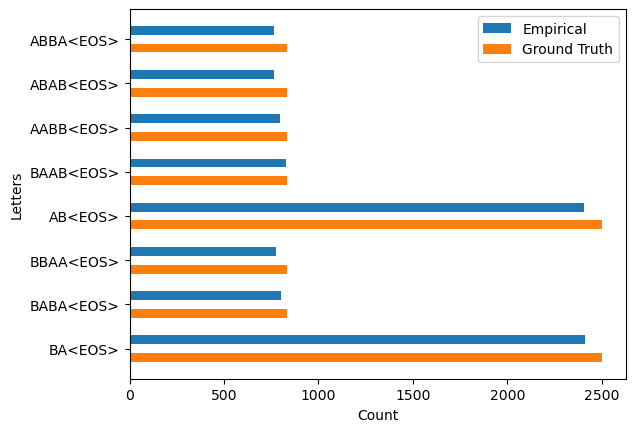

In [7]:
fig, ax = plt.subplots()


def is_valid(sequence):
    if not sequence.endswith("<EOS>"):
        return False
    # Remove the "<EOS>" from the end of the sequence
    sequence = sequence[:-5]
    counts = {i: sequence.count(get_letter(i)) for i in range(n_characters)}
    values = list(counts.values())
    if not len(values):
        return False
    return (
        all(value == values[0] for value in values)
        and values[0] > 0
        and values[0] <= max_repeats
    )


def count_permutations(repeats):
    true_count = 1
    for j in range(n_characters):
        true_count *= math.comb((n_characters - j) * repeats, repeats)
    return true_count


counter = Counter()
heatmap_counter = Counter()
valid = 0
invalid = 0
n_samples = 10000

sample_batch_size = 256
for i in range(n_samples):
    if i % sample_batch_size == 0:
        sample_sequences, x_0_sequences = sample(
            batch_size=sample_batch_size, return_x_0=True
        )
    sample_sequence = sample_sequences[i % sample_batch_size]
    x_0_sequence = x_0_sequences[i % sample_batch_size]
    if is_valid(sample_sequence):
        valid += 1
        counter[sample_sequence] += 1
        heatmap_counter[x_0_sequence + ";" + sample_sequence] += 1
    else:
        invalid += 1
    if i % 100 == 99:
        print(f"Valid sequences {valid}/{valid + invalid}")

ax.barh(
    [j + 0.2 for j in range(len(counter))],
    list(counter.values()),
    height=0.2,
    label="Empirical",
)
ax.barh(
    [j - 0.2 for j in range(len(counter))],
    [
        (
            (i + 1)
            / (count_permutations((len(k) - 5) // n_characters) * max_repeats)
            if is_valid(k)
            else 0.0
        )
        for k in counter.keys()
    ],
    height=0.2,
    label="Ground Truth",
)
ax.set_yticks(range(len(counter)))
ax.set_yticklabels(list(counter.keys()))
ax.legend()
ax.set_xlabel("Count")
ax.set_ylabel("Letters")

# p(X0|X1) Heatmap

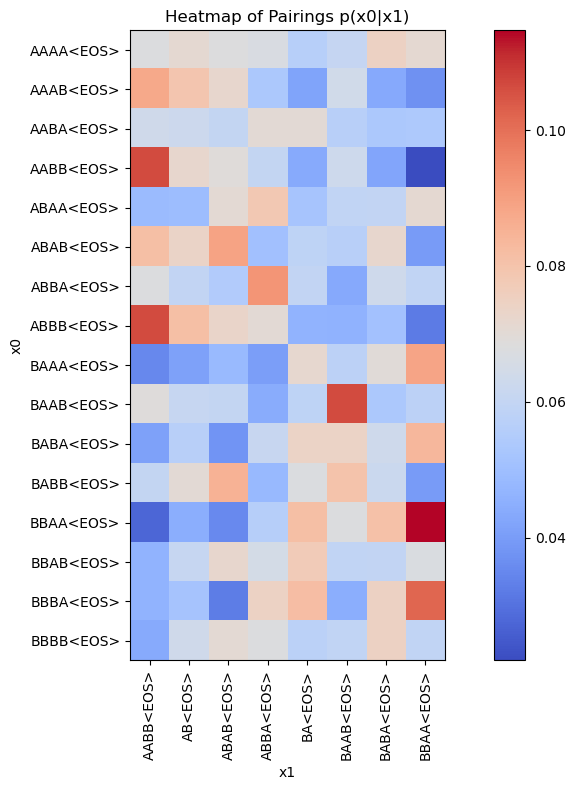

In [11]:
x_0_sequences = set()
sample_sequences = set()
for key in heatmap_counter.keys():
    x_0_sequence, sample_sequence = key.split(";")
    x_0_sequences.add(x_0_sequence)
    sample_sequences.add(sample_sequence)

x_0_sequences = sorted(list(x_0_sequences))
sample_sequences = sorted(list(sample_sequences))

frequency_array = np.zeros((len(x_0_sequences), len(sample_sequences)))

for i, x_0_sequence in enumerate(x_0_sequences):
    for j, sample_sequence in enumerate(sample_sequences):
        key = x_0_sequence + ";" + sample_sequence
        frequency_array[i, j] = heatmap_counter.get(key, 0)

frequency_array = frequency_array / np.sum(frequency_array, axis=0, keepdims=True)

plt.figure(figsize=(10, 8))
plt.imshow(frequency_array, cmap="coolwarm", interpolation="nearest")
plt.title("Heatmap of Pairings p(x0|x1)")
plt.xticks(np.arange(len(sample_sequences)), sample_sequences, rotation=90)
plt.xlabel("x1")
plt.yticks(np.arange(len(x_0_sequences)), x_0_sequences)
plt.ylabel("x0")
plt.colorbar()
plt.tight_layout()
plt.show()

# Distribution of lengths

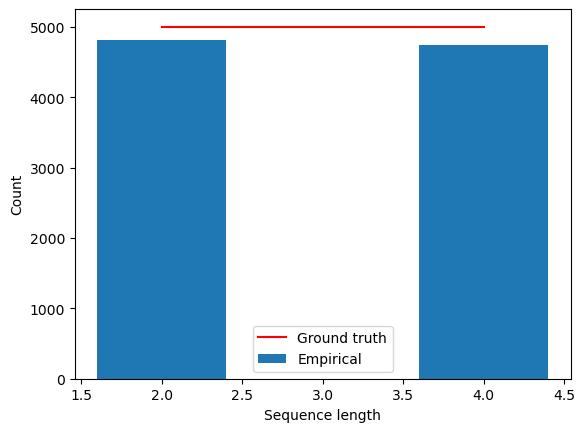

In [12]:
plt.figure()
plt.bar(
    [2 * i for i in range(1, max_repeats + 1)],
    [
        sum(
            [
                v
                for k, v in counter.items()
                if (len(k) - 5 == 2 * i and is_valid(k))
            ]
        )
        for i in range(1, max_repeats + 1)
    ],
    label="Empirical",
)
plt.plot(
    [2 * i for i in range(1, max_repeats + 1)],
    [n_samples / max_repeats for i in range(1, max_repeats + 1)],
    c="r",
    label="Ground truth",
)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.legend()
plt.show()

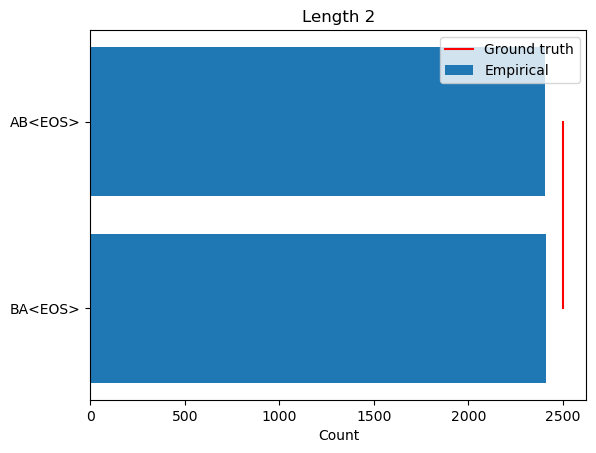

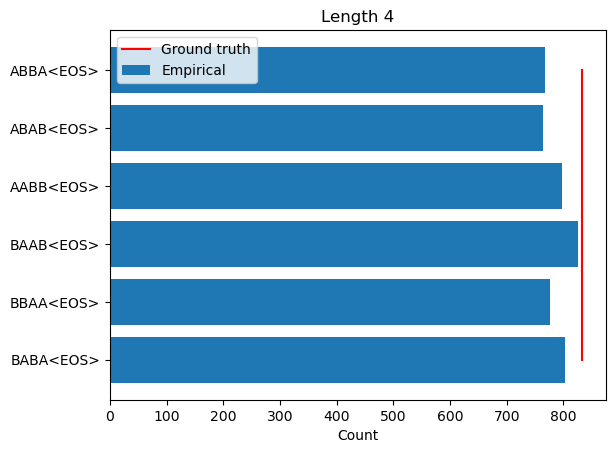

In [13]:
for i in range(1, max_repeats + 1):
    fig, ax = plt.subplots()
    plt.title(f"Length {2 * i}")
    filtered_sequences = [
        k for k in counter.keys() if (is_valid(k) and len(k) - 5 == 2 * i)
    ]
    plt.barh(
        range(len(filtered_sequences)),
        list([counter[k] for k in filtered_sequences]),
        label="Empirical",
    )
    ax.set_yticks(range(len(filtered_sequences)))
    ax.set_yticklabels(list(filtered_sequences))
    true_count = count_permutations(i)
    plt.plot(
        [n_samples / (true_count * max_repeats) for _ in range(true_count)],
        range(true_count),
        c="r",
        label="Ground truth",
    )
    plt.legend()
    plt.xlabel("Count")
    plt.show()